In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
engine

Engine(sqlite:///Resources/hawaii.sqlite)

In [9]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(autoload_with=engine)

In [10]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [13]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [14]:
# Create our session (link) from Python to the DB
session = Session(engine)
session

# Exploratory Precipitation Analysis

In [16]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(measurement.date)).scalar()
most_recent_date

'2017-08-23'

In [22]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
most_recent_date = session.query(func.max(measurement.date)).scalar()
one_year = dt.datetime.strptime(most_recent_date, "%Y-%m-%d") - dt.timedelta(days=365)
one_year

datetime.datetime(2016, 8, 23, 0, 0)

In [28]:
# Perform a query to retrieve the data and precipitation scores
data = (
    session.query(measurement.date, func.avg(measurement.prcp))
    .filter(measurement.date >= one_year)
    .group_by(measurement.date)
    .all()
)
# Extract the date and precipiation values
date = [row[0] for row in data]
precipitation = [row[1] for row in data]

In [33]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(data, columns = ["date","prcp"])
df.date = pd.to_datetime(df.date)

# Set index to date column so date appears in the plot
df.set_index("date", inplace=True)

# Sort the dataframe by date
df.sort_values('date')


,prcp
date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667
...,...
2017-08-19,0.030000
2017-08-20,0.005000
2017-08-21,0.193333


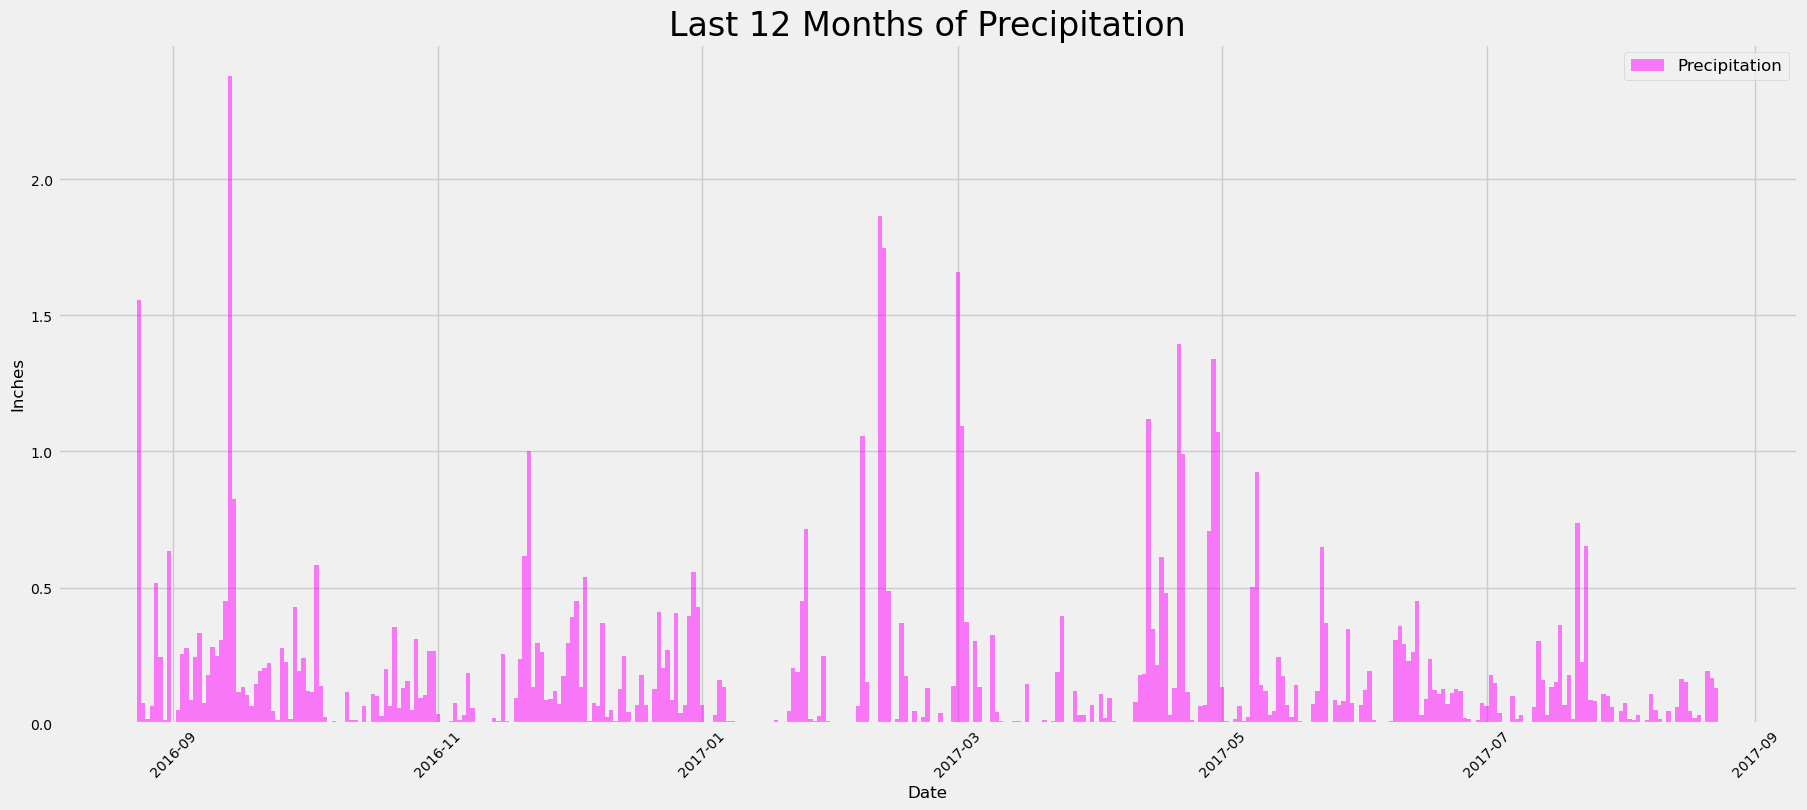

In [62]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(20,10))

plt.bar(df.index, df ['prcp'], width=1, color='magenta', alpha=.5)
plt.xticks(rotation=45)
plt.title('Last 12 Months of Precipitation', fontsize=24)
plt.xlabel('Date', fontsize=12)
plt.tick_params(axis='x', labelsize=10)
plt.ylabel('Inches', fontsize=12)
plt.tick_params(axis='y', labelsize=10)
plt.legend(['Precipitation'], fontsize=12)
plt.show
# Save as JPG
plt.subplots_adjust(bottom=0.2)  # Increase the bottom margin
plt.savefig('precipitation-plot.jpg', dpi=300)

In [63]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,prcp
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


# Exploratory Station Analysis

In [66]:
# Design a query to calculate the total number of stations in the dataset
n_stations = session.query(station).count()
print(n_stations)

9


In [71]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active = (
    session.query(measurement.station, func.count(measurement.station))
    .group_by(measurement.station)
    .order_by(func.count(measurement.station).desc())
    .all()
)
for station, count in most_active:
        print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [73]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_id = most_active[0][0]
min_temp = (session.query(func.min(measurement.tobs)).filter(measurement.station == most_active_id).scalar())
max_temp = (session.query(func.max(measurement.tobs)).filter(measurement.station == most_active_id).scalar())
avg_temp = (session.query(func.avg(measurement.tobs)).filter(measurement.station == most_active_id).scalar())
print(f"Min Temp: {round(min_temp, 2)}")
print(f"Max Temp: {round(max_temp, 2)}")
print(f"Avg Temp: {round(avg_temp, 2)}")

Min Temp: 54.0
Max Temp: 85.0
Avg Temp: 71.66


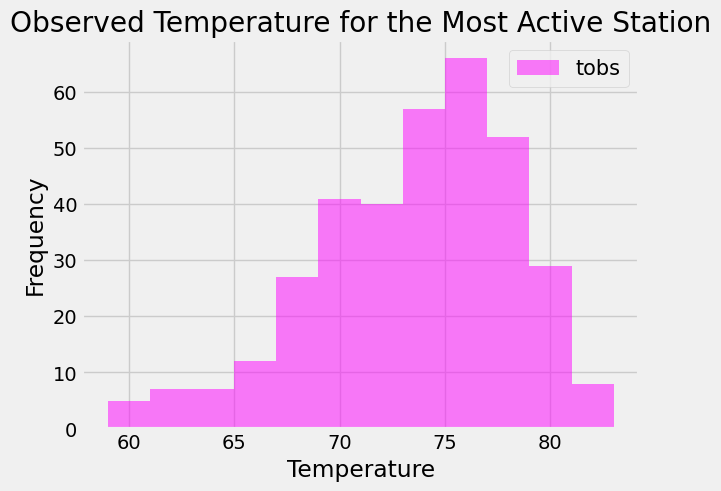

<Figure size 640x480 with 0 Axes>

In [77]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station

# A. Start by getting the most recent date in the measurement table
most_recent = (session.query(measurement.date).order_by(measurement.date.desc()).first())[0]

# B. Then convert the string to a datetime value
most_recent = dt.datetime.strptime(most_recent, "%Y-%m-%d")

# C. Then calculate the date one year prior
one_year_prior = most_recent - dt.timedelta(days=365)

# D. Create query for temperature data
temperature_data = (
    session.query(measurement.tobs)
    .filter(measurement.station == most_active_id)
    .filter(measurement.date >= one_year_prior)
    .all()
)

# E. Extract temperature from query
temperatures = [temp[0] for temp in temperature_data]

# Plot the results as a histogram
plt.hist(temperatures, bins=12, color='magenta', alpha=.5)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Observed Temperature for the Most Active Station")
plt.legend(['tobs'], fontsize=15)
plt.show()

# Save JPG
plt.savefig('temperature.jpg', dpi = 300)

# Close Session

In [76]:
# Close Session
session.close()